In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from numpy.typing import NDArray
import pandas as pd
from scipy.integrate import solve_ivp

# Implementing the SEIR model

In [2]:
@dataclass
class SEIRParams:
    """
    The model params for the SEIR.

    Parameters
    ----------
    alpha: float
    Transition rate from Exposed to Infected.

    beta: float
    The force of infection.

    gamma: float
    The rate of recovery from the infection.

    N: int
    Size of the population

    Attributes
    ---------
    alpha: float
    Transition rate from Exposed to Infected.

    beta: float
    .

    gamma: float
    The rate of recovery from the infection.

    N: int
    Size of the population

    """
    alpha:float
    beta:float
    gamma:float
    N: int

    def updatebeta(self, newbeta)->None:
        self.beta = newbeta
        return None


def seir_diff(t, state:NDArray, seirparams: SEIRParams)->NDArray:
    """
    The difference function, returns the change of number of individuals in a
    compartment per day.

    Parameters
    ---------
    state: NDArray
        The state array of length four, containing the number of individuals in
        rach of the compartment.

    seirparams:SEIRParams
        The SEIRParams object containing the parameters of the SEIR model.
    """
    assert state.ndim ==1
    assert state.shape[0] == 4
    alpha = seirparams.alpha
    beta = seirparams.beta
    gamma = seirparams.gamma
    N = seirparams.N
    return np.array([
        -beta*state[0]*state[2]/N,
        beta*state[0]*state[2]/N - alpha*state[1],
        alpha*state[1] - gamma*state[2],
        gamma*state[2]
        ])


In [3]:
N = 70000000
alpha = 1/5.8 # days inverse
gamma = 1/5 # days inverse
beta = 1
# initialise the parameters of the SEIR simulation
seirparam = SEIRParams(
    alpha = alpha,
    beta = beta,
    gamma=gamma,
    N =N
)

print(seirparam)

SEIRParams(alpha=0.1724137931034483, beta=1, gamma=0.2, N=70000000)


In [4]:
#define some initial condition
e, inf, r = 100, 1000, 0
initcondition = [N-e-inf-r, e, inf, r]
# Solve the differential equations
tspan  = (0, 80)
teval = np.linspace(tspan[0], tspan[1], tspan[1]+1)
soln = solve_ivp(
    fun=seir_diff,
    t_span=(0,80),
    t_eval=teval,
    y0 = initcondition,
    args = (seirparam,)
    )

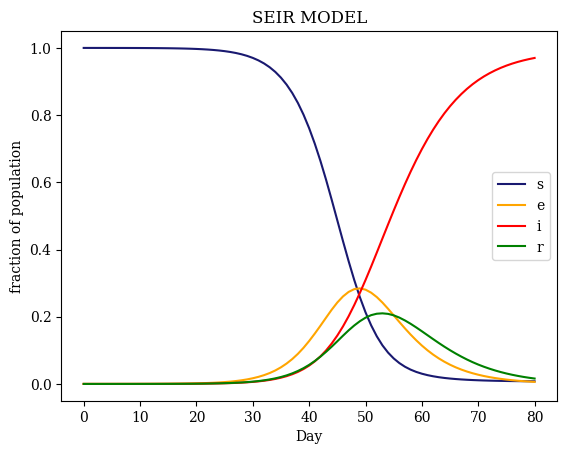

In [5]:
plt.rcParams['font.family'] = 'serif'
colors = ['midnightblue', 'orange', 'red', 'green']
plt.plot(soln.t, soln.y[0]/N, label = 's', color = colors[0])
plt.plot(soln.t, soln.y[1]/N, label = 'e', color = colors[1])
plt.plot(soln.t, soln.y[3]/N, label = 'i', color = colors[2])
plt.plot(soln.t, soln.y[2]/N, label = 'r', color = colors[3])
plt.title('SEIR MODEL')
plt.xlabel('Day')
plt.ylabel('fraction of population')

plt.legend()
plt.show()

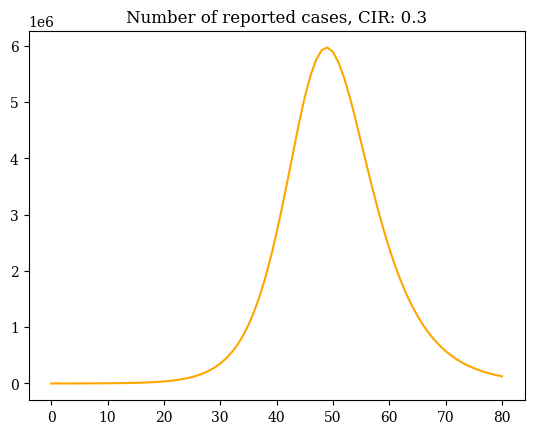

In [6]:
cir = 0.3
plt.title(f'Number of reported cases, CIR: {cir}')
plt.plot(soln.t, soln.y[1]*cir, color = colors[1])
plt.show()

In [7]:
#just checking if at all the points the sum
# fraction of people in each compartment adds up to one
assert np.all(np.isclose((soln.y[0]/N+\
soln.y[1]/N+\
soln.y[3]/N+\
soln.y[2]/N), 1))

# Loading the data

In [8]:
dataframe = pd.read_csv('cases.csv')

In [9]:
dataframe.dtypes

state         object
2020-04-01     int64
2020-04-02     int64
2020-04-03     int64
2020-04-04     int64
               ...  
2022-01-25     int64
2022-01-26     int64
2022-01-27     int64
2022-01-28     int64
2022-01-29     int64
Length: 670, dtype: object

In [10]:
# I am assuming that the data is already clean and
# the dates are ordered such that i can just do the following
wave_1 = ('2020-06-20','2020-07-31' )
wave_2 = ('2021-03-21','2021-04-26' )
wave_3 = ('2022-01-01','2022-01-20' )

#get the indices of columns corrsponding to the waves
wave_1_inds = (dataframe.columns.get_loc(wave_1[0]),
               dataframe.columns.get_loc(wave_1[1])
)
wave_2_inds = (dataframe.columns.get_loc(wave_2[0]),
               dataframe.columns.get_loc(wave_2[1])
)
wave_3_inds = (dataframe.columns.get_loc(wave_3[0]),
               dataframe.columns.get_loc(wave_3[1])
)

# get the array of the confirmed cases
wave_1_cases_confirmed = dataframe.iloc[0, wave_1_inds[0]: wave_1_inds[1]].array
wave_1_cases_confirmed = np.array(wave_1_cases_confirmed)
wave_1_new_cases_confirmed = np.diff(wave_1_cases_confirmed) 

wave_2_cases_confirmed = dataframe.iloc[0, wave_2_inds[0]: wave_2_inds[1]].array
wave_2_cases_confirmed = np.array(wave_2_cases_confirmed)
wave_2_new_cases_confirmed = np.diff(wave_2_cases_confirmed)

wave_3_cases_confirmed = dataframe.iloc[0, wave_3_inds[0]: wave_3_inds[1]].array
wave_3_cases_confirmed = np.array(wave_3_cases_confirmed)
wave_3_new_cases_confirmed = np.diff(wave_3_cases_confirmed)


# Compute the running average

In [11]:
# use convolve to compute the running average array
# Unsure of what the boubdaries are
#Define an array of 1/7 for the running average
filter_avg = np.ones(shape= (7,))/7

running_avg_wave_1_new_confirmed = np.convolve(
    wave_1_new_cases_confirmed,
    filter_avg,
    mode = 'valid'
    )

running_avg_wave_2_new_confirmed = np.convolve(
    wave_2_new_cases_confirmed,
    filter_avg,
    mode = 'valid'
    )

running_avg_wave_3_new_confirmed = np.convolve(
    wave_3_new_cases_confirmed,
    filter_avg,
    mode = 'valid'
    )
# np.convolve()

In [ ]:
# define the loss function
# Why does this loss function work?


def loss(
        unknowns_estimate: tuple|list,
        knowns:tuple|list,
        steps:int,
        new_reported_cases_perday_winavg: NDArray
        )->float:
    """
    The loss function for computing the parameters
    of the SEIR model.
    
    Parameters
    ----------
    unknowns_estimate: tuple|list
        The unknown parameters for the seir simulation: (beta, E[0], I[0], R[0], CIR).
    knowns: tuple|list
        The known parameters, _alpha_, _gamma_ and N for the seir simulation
        passed in the same order in form of a tuple.
    steps: int
        The number of days to simulate the seir model for.
    new_reported_cases_perday_winavg: NDArray
        The number of confirmed new daywise cases.
    """
    # Unpacking the known and unknown params for
    # more readability
    alpha, gamma, N = knowns
    beta, e_ini, inf_ini, recovered_ini, cir = unknowns_estimate
    # Define s(0) = N - e-i-r
    s_ini = N - e_ini - inf_ini- recovered_ini
    # Defining the parameters for the simulation
    seirparam = SEIRParams(
        alpha= alpha,
        beta=beta,
        gamma=gamma,
        N=N
    )
    # the _surmised_ initial condition
    initcondition = np.array([s_ini, e_ini, inf_ini, recovered_ini])
    teval = np.linspace(0,steps-1, steps)
    solution = solve_ivp(
        fun= seir_diff,
        t_eval= teval,
        args=(seirparam)
    )
    getstatearr = solution.y
    assert solution.y.shape[1] == steps
    # "Theoretically" predicted confirmed infections per day
    e_t = cir*solution.y[1,:]*alpha
    del solution
    # get the running average
    filter_conv = np.ones((7,))/7
    predicted_confired_cases_per_day_winavg = np.convolve(
        filter_conv,
        e_t,
        mode= 'valid'
        )
    #compute the loss and return
    loss = np.sum(
        (np.log(new_reported_cases_perday_winavg)-\
         np.log(predicted_confired_cases_per_day_winavg)
         )**2
         )
    return loss

    

In [ ]:
from scipy import optimize
# Use a optimizer to compute the unknown parameters
optimize.fmin_bfgs